Efficiency Toy
====

Example of the efficiency correction procedure using multiple distributions

In [1]:
# Just some boilerplate code
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

from matplotlib import rcParams

rcParams["figure.figsize"] = (10.0, 8.0)

rng = np.random.default_rng()
pdf_domain = (-3, 7)
pdf_range = (0, 1.0)


def sample(N, pdf):
    """
    Use accept-reject sampling to get N samples from pdf
    
    slow
    
    """
    points = np.zeros(N)
    num_generated = 0

    while num_generated < N:
        # Generate a point
        x = pdf_domain[0] + (pdf_domain[1] - pdf_domain[0]) * rng.random()
        y = pdf_range[0] + (pdf_range[1] - pdf_range[0]) * rng.random()

        if y < pdf(x):
            points[num_generated] = x
            num_generated += 1

    return points

We have three different distributions - call them WS, RS ("wrong/right sign") and phsp.
We can generate these from the models ("model sample") or via LHCb Monte Carlo ("MC sample").

The MC samples are affected by the efficiency- by comparing the MC sample to the model samples
We can extract the efficiency function $\epsilon(x)$.

We have three models; their PDFs are $\mathcal{A}_{RS}(x)$, $\mathcal{A}_{WS}(x)$ and $\mathcal{A}_{phsp}(x)$.
The corresponding PDFs describing the MC are $\mathcal{A}_{RS}(x)\epsilon(x)$, etc.

The PDF describing the combined model samples is:
$p_{model}(x) = \mathcal{I}_{RS}\mathcal{A}_{RS}(x) + \mathcal{I}_{WS}\mathcal{A}_{WS}(x) + \mathcal{I}_{phsp}\mathcal{A}_{phsp}(x)$; the PDF describing the combined MC samples is this multiplied by $\epsilon(x)$. $\mathcal{I}_i$ are numerical factors that can be found from the relative statistics of the MC samples.

Below is a toy example of the procedure used to find the efficiency.

First we need to generate MC samples:

In [8]:
# Model "PDFs" - not normalised (on purpose, since in reality amplitude models are rarely normalised)
A_rs = lambda x: 1.1 * norm.pdf(x, loc=0, scale=1)
A_ws = lambda x: 0.9 * norm.pdf(x, loc=3, scale=0.8)
A_phsp = lambda x: 0.5 * int(pdf_domain[0] < pdf_domain[1])

efficiency = lambda x: 0.9 + 0.1 * np.sin(x)
A_rs_mc = lambda x: efficiency(x) * A_rs(x)
A_ws_mc = lambda x: efficiency(x) * A_ws(x)
A_phsp_mc = lambda x: efficiency(x) * A_phsp(x)

In [9]:
# Generate different numbers of points from each distribution
mc_rs_sample = sample(20000, A_rs_mc)
mc_ws_sample = sample(40000, A_ws)
mc_phsp_sample = sample(20000, A_phsp)

Next we need to find the weights $\mathcal{I}_i$ describing the combined model:

In [10]:
I_rs, I_ws, I_phsp = 0.0, 0.0, 0.0

for p in mc_rs_sample:
    I_rs += 1 / A_rs_mc(p)
for p in mc_ws_sample:
    I_ws += 1 / A_ws_mc(p)
for p in mc_phsp_sample:
    I_phsp += 1 / A_phsp_mc(p)

# Scale the weights to something more sensible
scale_factor = I_rs + I_ws + I_phsp
I_rs /= scale_factor
I_ws /= scale_factor
I_phsp /= scale_factor

We can then construct the model PDF. This, when multiplied by the efficiency, should also describe the MC sample.

We can recover the efficiency function by taking a sample from the combined model PDF and comparing it to the combined MC samples:

In [12]:
# Take a sample from the combined PDF
combined_sample = sample(90000, combined_pdf)

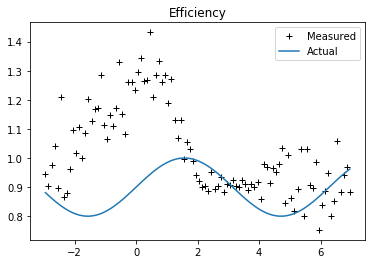

In [13]:
# Make histograms of the model + MC, find their ratio
model_hist, bins = np.histogram(combined_sample, bins=100, density=True)
mc_hist, _ = np.histogram(np.concatenate((mc_rs_sample, mc_ws_sample, mc_phsp_sample)), bins=bins, density=True)

bin_centres = (bins[1:] + bins[:-1]) / 2
hist_ratio = mc_hist / model_hist
ideal_efficiency = [efficiency(x) for x in bin_centres]

plt.plot(bin_centres, hist_ratio, "k+", label="Measured")
plt.plot(bin_centres, ideal_efficiency, label="Actual")
plt.title("Efficiency")
plt.legend()
plt.show()